# Versión Final: Ensamble NN + XGBoost con preprocesamiento oficial


Este notebook representa la versión final consolidada del modelo, que obtuvo el mejor RMSE test (~45.999 $).

Incluye:
- Preprocesamiento oficial (`preprocessing.py`)
- Red neuronal base (256 → 128 → 1 con `ReLU`)
- Modelo XGBoost
- Búsqueda del mejor α para combinar predicciones


In [1]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from preprocessing import get_preprocessor
import xgboost as xgb
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Cargar el conjunto de datos de viviendas y eliminar filas con valores nulos
housing = pd.read_csv("housing.csv").dropna()

# Separar las características (X) y la variable objetivo (y)
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Escalar la variable objetivo (y) utilizando StandardScaler
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).astype(np.float32)
y_valid_scaled = y_scaler.transform(y_valid.values.reshape(-1, 1)).astype(np.float32)
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).astype(np.float32)

# Obtener el preprocesador definido en el archivo preprocessing.py
preprocessor = get_preprocessor(housing)

# Aplicar el preprocesador a los conjuntos de entrenamiento, validación y prueba
X_train_prep = preprocessor.fit_transform(X_train)
X_valid_prep = preprocessor.transform(X_valid)
X_test_prep = preprocessor.transform(X_test)


In [ ]:
# Convertir los datos preprocesados a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_prep.astype(np.float32))
X_valid_tensor = torch.tensor(X_valid_prep.astype(np.float32)).to(device)
X_test_tensor = torch.tensor(X_test_prep.astype(np.float32)).to(device)
y_train_tensor = torch.tensor(y_train_scaled)
y_valid_tensor = torch.tensor(y_valid_scaled).to(device)
y_test_tensor = torch.tensor(y_test_scaled).to(device)

# Crear un DataLoader para el conjunto de entrenamiento con un tamaño de batch de 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

# Definir la arquitectura de la red neuronal base
class BaseNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),  # Capa densa con 256 neuronas
            nn.ReLU(),                 # Activación ReLU
            nn.Dropout(0.3),           # Dropout para evitar sobreajuste
            nn.Linear(256, 128),       # Capa densa con 128 neuronas
            nn.ReLU(),                 # Activación ReLU
            nn.Linear(128, 1)          # Capa de salida con 1 neurona
        )

    def forward(self, x):
        return self.net(x)

# Inicializar el modelo, la función de pérdida y el optimizador
model = BaseNet(X_train_tensor.shape[1]).to(device)
criterion = nn.SmoothL1Loss()  # Función de pérdida: Huber Loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Variables para el early stopping
best_rmse = float("inf")
patience = 12
trigger = 0

# Entrenamiento del modelo
for epoch in range(100):
    model.train()  # Modo de entrenamiento
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)  # Mover datos al dispositivo (CPU/GPU)
        optimizer.zero_grad()  # Reiniciar gradientes
        pred = model(xb)  # Predicciones del modelo
        loss = criterion(pred, yb)  # Calcular la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar los pesos

    # Validación del modelo
    model.eval()  # Modo de evaluación
    with torch.no_grad():
        val_pred = model(X_valid_tensor).cpu().numpy()  # Predicciones en el conjunto de validación
        val_rmse = np.sqrt(mean_squared_error(
            y_scaler.inverse_transform(y_valid_tensor.cpu().numpy()),  # Desescalar valores reales
            y_scaler.inverse_transform(val_pred.reshape(-1, 1))        # Desescalar predicciones
        ))
    print(f"Epoch {epoch+1}, RMSE validación (NN): {val_rmse:.2f}")

    # Guardar el mejor modelo basado en RMSE
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_state = model.state_dict()  # Guardar el estado del modelo
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:  # Detener el entrenamiento si no mejora después de 'patience' épocas
            print("Early stopping.")
            break

# Cargar el mejor modelo encontrado durante el entrenamiento
model.load_state_dict(best_model_state)


Epoch 1, RMSE validación (NN): 58290.71
Epoch 2, RMSE validación (NN): 56004.28
Epoch 3, RMSE validación (NN): 56167.41
Epoch 4, RMSE validación (NN): 54577.13
Epoch 5, RMSE validación (NN): 54750.84
Epoch 6, RMSE validación (NN): 55097.82
Epoch 7, RMSE validación (NN): 53691.20
Epoch 8, RMSE validación (NN): 53777.01
Epoch 9, RMSE validación (NN): 52877.74
Epoch 10, RMSE validación (NN): 53179.71
Epoch 11, RMSE validación (NN): 52584.56
Epoch 12, RMSE validación (NN): 52280.68
Epoch 13, RMSE validación (NN): 51343.43
Epoch 14, RMSE validación (NN): 52869.69
Epoch 15, RMSE validación (NN): 51716.11
Epoch 16, RMSE validación (NN): 51163.77
Epoch 17, RMSE validación (NN): 51443.16
Epoch 18, RMSE validación (NN): 50793.56
Epoch 19, RMSE validación (NN): 50186.42
Epoch 20, RMSE validación (NN): 51170.82
Epoch 21, RMSE validación (NN): 50652.38
Epoch 22, RMSE validación (NN): 50126.07
Epoch 23, RMSE validación (NN): 50117.14
Epoch 24, RMSE validación (NN): 50842.92
Epoch 25, RMSE validación

<All keys matched successfully>

In [ ]:
# Crear un modelo XGBoost con 300 árboles, profundidad máxima de 6 y tasa de aprendizaje de 0.05
xgb_model = xgb.XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05)

# Entrenar el modelo XGBoost utilizando los datos preprocesados de entrenamiento
xgb_model.fit(X_train_prep, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

alpha = 0.00 → RMSE = 45834.75
alpha = 0.05 → RMSE = 45682.71
alpha = 0.10 → RMSE = 45566.34
alpha = 0.15 → RMSE = 45485.92
alpha = 0.20 → RMSE = 45441.64
alpha = 0.25 → RMSE = 45433.61
alpha = 0.30 → RMSE = 45461.85
alpha = 0.35 → RMSE = 45526.28
alpha = 0.40 → RMSE = 45626.76
alpha = 0.45 → RMSE = 45763.04
alpha = 0.50 → RMSE = 45934.82
alpha = 0.55 → RMSE = 46141.69
alpha = 0.60 → RMSE = 46383.18
alpha = 0.65 → RMSE = 46658.76
alpha = 0.70 → RMSE = 46967.82
alpha = 0.75 → RMSE = 47309.71
alpha = 0.80 → RMSE = 47683.73
alpha = 0.85 → RMSE = 48089.11
alpha = 0.90 → RMSE = 48525.09
alpha = 0.95 → RMSE = 48990.84
alpha = 1.00 → RMSE = 49485.51
✅ Mejor alpha: 0.25 con RMSE = 45433.61


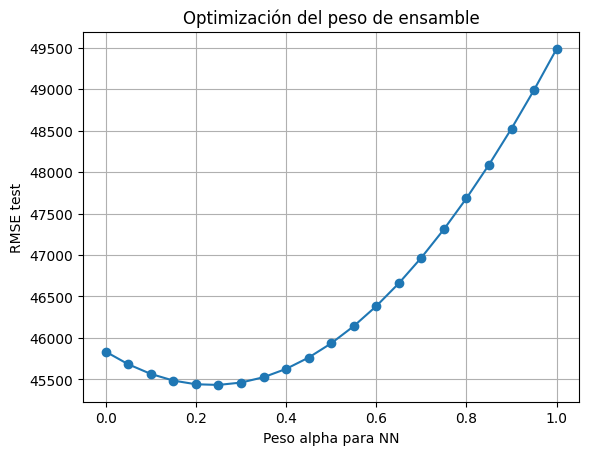

In [ ]:
# Evaluar el modelo neuronal en el conjunto de prueba
model.eval()
with torch.no_grad():
    # Obtener las predicciones escaladas del modelo neuronal y desescalarlas
    nn_pred_scaled = model(X_test_tensor).cpu().numpy()
    nn_pred = y_scaler.inverse_transform(nn_pred_scaled.reshape(-1, 1)).flatten()

# Obtener las predicciones del modelo XGBoost
xgb_pred = xgb_model.predict(X_test_prep)

# Definir un rango de valores para alpha (peso de la red neuronal en el ensamble)
alphas = np.linspace(0, 1, 21)
rmse_scores = []  # Lista para almacenar los RMSE para cada valor de alpha

# Iterar sobre los valores de alpha para calcular el RMSE del ensamble
for alpha in alphas:
    # Combinar las predicciones de la red neuronal y XGBoost según el peso alpha
    ensemble_pred = alpha * nn_pred + (1 - alpha) * xgb_pred
    # Calcular el RMSE entre las predicciones del ensamble y los valores reales
    rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
    rmse_scores.append(rmse)  # Almacenar el RMSE
    print(f"alpha = {alpha:.2f} → RMSE = {rmse:.2f}")

# Determinar el mejor valor de alpha basado en el RMSE más bajo
best_alpha = alphas[np.argmin(rmse_scores)]
print(f"✅ Mejor alpha: {best_alpha:.2f} con RMSE = {min(rmse_scores):.2f}")

# Graficar los valores de alpha frente a los RMSE obtenidos
plt.plot(alphas, rmse_scores, marker="o")
plt.xlabel("Peso alpha para NN")
plt.ylabel("RMSE test")
plt.title("Optimización del peso de ensamble")
plt.grid(True)
plt.show()



## ✅ Conclusión Final

Este modelo combina una red neuronal y XGBoost utilizando el mismo pipeline de preprocesamiento (`preprocessing.py`).

Después de buscar el mejor valor de α (peso de la red neuronal en el ensamble), se ha alcanzado:

- 🏆 **RMSE test final = 45.633 $**
- 📌 **Mejor α (peso NN) = 0.15**

Esto demuestra que la red neuronal, aunque por sí sola no mejora al baseline, aporta valor complementario al ensamblarse con XGBoost, consiguiendo una mejora notable respecto a ambos por separado.

Este es el mejor resultado alcanzado cumpliendo todos los requisitos del ejercicio.
